# Python Assignment - Jarvis March Algorithm

The original algorithm was given was:

S is a set of points in a plane. p,q and r are in S.

1) Initialise p as leftmost point.
2) Do following while we do not come back to the first (or leftmost) point.
    1) The next point q is the point such that the triplet (p, q, r) is counterclockwise for any other point r.
    2) next[p] = q (Store q as next of p in the output convex hull).
    3) p = q (Set p as q for next iteration).


## The problem with this code:
This pseudocode is not unambiguous. Specfic algorithmic words like 'for' and 'while' should be clearly labelled e.g. "begin While", "end While". There is also not consistancy between when plain English is prioritised vs code/maths language. For example steps 1,2 and A are in plain English but steps B and C are denoted using python style indexing and then further explained by plain English in brackets. I think either style is fine but it should be consistant between which is used. There is also no clear/explicit statement of when to add $p$ to the hull.

Below is improved pseudocode for the Jarvis March Algorithm:

$S \subset \mathbb{R}^2$ is a set of points with $|S|>3$. Let $p,q,i \in S$.
The aim of this algorithm is to find a subset of points that, when joined with straight lines, fully contain every point in $S$.

1) Define the $l$ as the left most point in the set $S$.
2) Initalise empty convex hull, initalise $p=l$ as the left most point in the set, and intitalise $q=0$.
3) Begin WHILE
    1) Add $p$ to the convex hull
    2) Set $q$ as the next point in the set. If $p$ is at the end of the set, wrap around to the beginning ($q = (p+1) \mod |S|$).
    3) Begin FOR each point $i$ in $S$
        1) If the triple $p,i,q$ is anticlockwise, set that point $i$ to be the new $q$.
    4) End FOR.
    5) Set $p=q$.
    6) If this $p$ is the same as the first point in the convex hull, end WHILE.

Technically, the object $l$ is unneeded - having $l$ as the left most point in the set and then setting $p$ equal to $l$ is merely so that, if someone else wanted to use this code and wanted to be able to return the starting point additionally to the full convex hull, they can. Otherwise the original $p$ gets overwritten.

I think my pseudo code is better because it is more clearly labelled, it explicitly says when to do each thing, and it states the caveats (e.g. the input must have a minimum size of 3).

Note for the code in this document; I was helped a lot by these two links in making my Jarvis March Algorithm:
https://www.geeksforgeeks.org/convex-hull-using-jarvis-algorithm-or-wrapping/
https://algorithmtutor.com/Computational-Geometry/Convex-Hull-Algorithms-Jarvis-s-March/
Therefore there may be similarities in the code.

In [1]:
# Set up a class specifically to have points more easily referenced.

class point :
    
    # defines a point in 2d space with an x and y coordinate.
    def __init__(self,x = 0.0,y = 0.0) :
        self.x = x
        self.y = y
        
    # defines a function that does addition of two points (this is pointwise addition
    # as is consistent with vector notation).   
    def add(a,b) :
        c = point()
        c.x = a.x + b.x
        c.y = a.y + b.y
        return  c
    
    # defines a function that does subtraction of two points (this is again pointwise but
    # obviously order is important with this function as opposed to 'add' where both
    # orderings of two points would return the same value).
    def subtract(a,b) :
        c = point()
        c.x = a.x - b.x
        c.y = a.y - b.y
        return  c
    
    # a function that will print out the point similar to mathematical notation of a row vector.
    def print(self) :
        print("(",self.x,",",self.y,")")
        
    # calculates the distance between two points.
    def dist(a,b):
        c = subtract(a,b)
        r = sqrt(c.x**2+c.y**2)
        return r
    
    # plots using matplotlib. Takes as input a list of points. It then plots them as a scatter plot.
    # if the additional argument hull is set to a result from jarvis_march (or just any list of ordered points,
    # but this is intended for use with outputs from jarvis_march) then it will add lines between successive
    # points in the hull.
    def plot(points,hull=None):
        l1 = [points[i].x for i in range(len(points))]
        l2 = [points[i].y for i in range(len(points))]
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        ax.scatter(l1, l2)
        if hull != None:
            for i in range(len(hull)-1):
                ax.plot([hull[i].x,hull[i+1].x],[hull[i].y,hull[i+1].y],color="red")
            ax.plot([hull[-1].x,hull[0].x],[hull[-1].y,hull[0].y],color="red")
            
    # takes as input two lists, where the first is a list of coordinates and the second is a list of y
    # coordinates. It then outputs a list where each object in the list is of class point with the respective
    # x and y coordinates.
    def list_to_points(S1,S2):
        points = [point(S1[i],S2[i]) for i in range(len(S1))]
        return points
    
    # calculates the dot product of two vectors/points. 
    def dot_product(a,b):
        prod = a.x*b.x + a.y*b.y
        return prod
    
    # calculates the angle between two vectors.
    def dot_product_inv(a,b):
        from math import sqrt, acos
        prod = a.x*b.x + a.y*b.y
        r1 = round(math.sqrt(a.x**2+a.y**2),12)
        r2 = round(math.sqrt(b.x**2+b.y**2),12)
        # these two if statements are trying to deal with rounding errors that can cause issues
        # with the inverse cosine.
        if r1>round(r1)-0.0001 and r1<round(r1)+0.0001: 
            r1=round(r1)
        if r2>round(r2)-0.0001 and r2<round(r2)+0.0001:
            r2=round(r2)  
        if r1==0 or r2==0 or (prod/(r1*r2))==1:
            theta = 0
        elif prod/(r1*r2)>=-1 and prod/(r1*r2)<=1:
            theta = math.acos(prod/(r1*r2))
        else:
            print(prod,r1,r2,point.print(a),point.print(b))
#       this final else statement prints all the information so that if the function isn't working
#       you can calculate it manually and find out why the code isn't working. I didn't fully make
#       this function work as I ended up not using it. I've only left it in as it's nice to have in
#       theory/for completeness.

        return theta


    # this is a function to calculate the orientation of three points; explained below.
    def orientation(p,q,r):
        
        # returns 0 if they are colinear.
        # returns 1 if they are clockwise.
        # returns -1 if they are anticlockwise.
        
        ori =  (r.x-q.x)*(q.y-p.y)-(r.y-q.y)*(q.x-p.x)
        if ori == 0:
            entation = 0
            return entation
        elif ori > 0:
            entation = 1
            return entation
        else:
            entation = -1
            return entation

The function point.orientation uses gradients to calculate if three points are clockwise or anti clockwise. This is well explained at https://www.geeksforgeeks.org/orientation-3-ordered-points/ but the basis idea is that for three points $p_1,p_2,p_3$ if the slope between $p_3$ and $p_2$ is greater than between $p_2$ and $p_1$ then the orientation is anticlockwise. In maths terms;
$$ \frac{(y_2-y_1)}{(x_2-x_1)} < \frac{(y_3-y_2)}{(x_3-x_2)} \implies \text{anticlockwise.}$$
The points are clockwise if you reverse the less than sign and colinear if the two are equal. This can be rearranged to $$ (y_2 - y_1)(x_3 - x_2) - (y_3 - y_2)(x_2 - x_1) $$ and thus the sign of this function decides the orientation.

In [2]:
# testing the orientation function. It works!
p1 = point(1,1)
p2 = point(2,3)
p3 = point(3,7)

point.orientation(p1,p2,p3)

-1

In [3]:
# writing the algorithm. have the inputs as two lists of x values and y values as thats what the data sets are.
def jarvis_march(S1,S2):
    
    # making sure each point has an x and y coordinate.
    if len(S1)!=len(S2):
        return "Input lists must be the same length"
    
    # making sure theres at least three points to caluclate the orientation of.
    if len(S1)<3 or len(S2)<3:
        return "Must be at least three points"
    
    # transforms the two lists to a list of points.
    points = point.list_to_points(S1,S2)
    
    

    # calculate the left most point's index within the list.
    left = S1.index(min(S1))
    
    # initialise the output list
    convex_hull = []
    
    # initialise p an q
    p = left    
    q = 0
    
    # run this while loop until the termination criteria is reached, where the next point in the convex hull
    # is the same as the first point i.e. we've reached the beginning again.
    while True:
        
        convex_hull.append(points[p]) # add the last point to the hull.
        
        q = (p+1) % len(points) # make q the next point in the list (looping around incase we're at the end
        # of the list 'points')
        
        # calculate the orientation. if it is anticlockwise update q to be that i, as it's got the 
        # most points clockwise to it.
        for i in range(len(points)):
            if point.orientation(points[p],points[i],points[q])==(-1):
                q=i

        # we now have a q as the next point in the convex hull. set p to this so in the next iteration
        # it will add this point to the hull.
        p = q
        
        # except don't add this point if we are back at the beginning of the hull! end the while loop.
        if p==left:
            break

    # return the convex hull
    return convex_hull

Now for a test dataset...

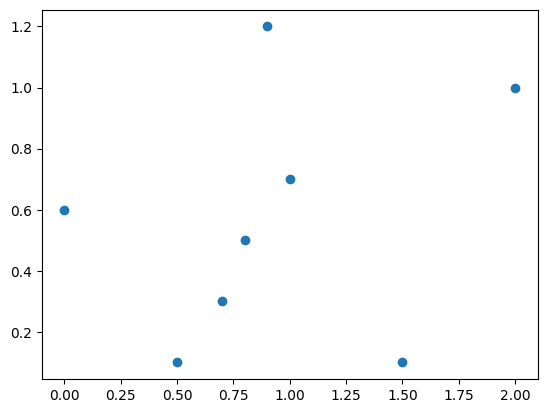

In [4]:
# plot the test data first
test1 = [0,1,2,0.7,1.5,0.8,0.5,0.9]
test2 = [0.6,0.7,1,0.3,0.1,0.5,0.1,1.2]
test3 = point.list_to_points(test1,test2)
point.plot(test3)

In [5]:
ch = jarvis_march(test1,test2)
[point.print(ch[i]) for i in range(len(ch))]
# print out the full list of the hull

( 0 , 0.6 )
( 0.5 , 0.1 )
( 1.5 , 0.1 )
( 2 , 1 )
( 0.9 , 1.2 )


[None, None, None, None, None]

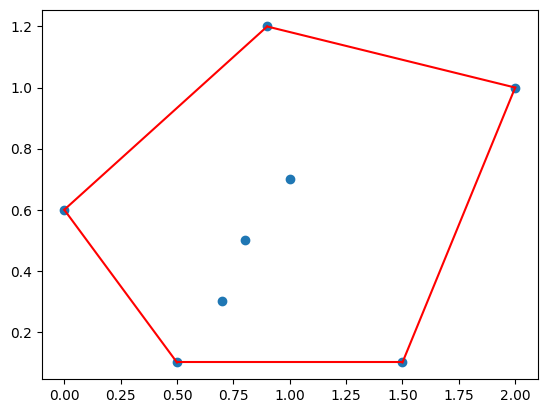

In [6]:
# plot the hull on top of the points
point.plot(test3,ch)

Now importing the first dataset, pines.

In [7]:
import csv

In [8]:
!pwd

/home/howellmf/STOR-601-env


In [9]:
!head pines.csv

1,0.1,9.9
2,0.1,7.2
3,0.2,6.2
4,0.2,8.4
5,0.7,4.5
6,0.9,7.5
7,1.1,8.5
8,1.3,6.3
9,1.4,1.6
10,1.6,5.4


In [10]:
# open the file
with open('pines.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    C1 = []
    C2 = []
    C3 = []
    # read each row of the file ...
    for row in csv_reader :
        # .. and put the data into the lists
        C1.append(row[0])
        C2.append(row[1])
        C3.append(row[2])

# have a look
print(C1,C2,C3)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'] ['0.1', '0.1', '0.2', '0.2', '0.7', '0.9', '1.1', '1.3', '1.4', '1.6', '1.7', '1.7', '2', '2.1', '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.8', '3.3', '3.3', '3.6', '3.7', '3.9', '3.9', '3.9', '4.1', '4.5', '4.8', '4.9', '5.2', '5.2', '5.3', '5.3', '5.6', '5.8', '5.9', '6', '6.1', '6.1', '6.1', '6.3', '6.5', '6.6', '6.6', '6.9', '7.2', '7.2', '7.3', '7.4', '7.4', '7.5', '7.6', '7.9', '8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '9.2', '9.2', '9.3', '9.4', '9.4', '9.5', '9.5', '9.5'] ['9.9', '7.2', '6.2', '8.4', '4.5', '7.5', '8.5', '6.3', '1.6', '5.4', '2.6', '4.1', '0.

In [11]:
# convert dataset from strings
C1 = [int(x) for x in C1]
C2 = [float(x) for x in C2]
C3 = [float(x) for x in C3]
print(C1,C2,C3)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71] [0.1, 0.1, 0.2, 0.2, 0.7, 0.9, 1.1, 1.3, 1.4, 1.6, 1.7, 1.7, 2.0, 2.1, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.8, 3.3, 3.3, 3.6, 3.7, 3.9, 3.9, 3.9, 4.1, 4.5, 4.8, 4.9, 5.2, 5.2, 5.3, 5.3, 5.6, 5.8, 5.9, 6.0, 6.1, 6.1, 6.1, 6.3, 6.5, 6.6, 6.6, 6.9, 7.2, 7.2, 7.3, 7.4, 7.4, 7.5, 7.6, 7.9, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 9.2, 9.2, 9.3, 9.4, 9.4, 9.5, 9.5, 9.5] [9.9, 7.2, 6.2, 8.4, 4.5, 7.5, 8.5, 6.3, 1.6, 5.4, 2.6, 4.1, 0.2, 8.0, 8.7, 1.1, 7.0, 5.7, 5.4, 4.2, 2.6, 5.2, 6.3, 5.9, 8.0, 3.4, 4.7, 9.1, 1.7, 2.3, 5.3, 6.3, 4.3, 7.5, 9.8, 1.3, 7.8, 1.8, 6.8, 5.5, 4.3, 3.2, 2.5, 4.1, 8.1, 8.9, 1.6, 0.4, 5.2, 6.0, 4.2, 3.6, 5.4, 9.3, 1.7, 8.5, 4.5, 6.7, 1.0, 3.2, 2.0, 0.9, 8.7, 6.0, 8.1, 0.8, 1.0, 2.6, 2.3, 4.6, 6.2]


In [12]:
# make a list of all the points
C4 = point.list_to_points(C2,C3)

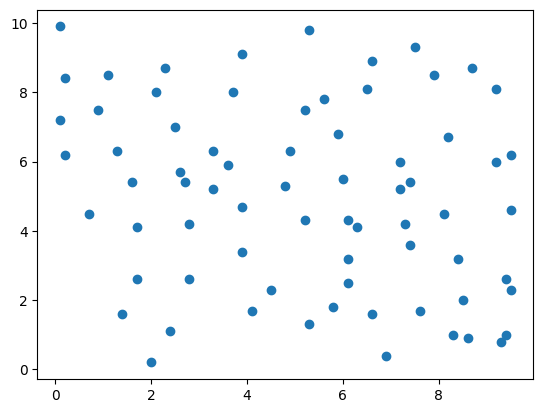

In [13]:
# plot the points
point.plot(C4)

In [14]:
# find the convex hull of the pines dataset
jm1 = jarvis_march(C2,C3)

In [15]:
# look at the convex hull
[point.print(jm1[i]) for i in range(len(jm1))]

( 0.1 , 9.9 )
( 0.1 , 7.2 )
( 0.2 , 6.2 )
( 1.4 , 1.6 )
( 2.0 , 0.2 )
( 6.9 , 0.4 )
( 9.3 , 0.8 )
( 9.4 , 1.0 )
( 9.5 , 2.3 )
( 9.5 , 4.6 )
( 9.5 , 6.2 )
( 9.2 , 8.1 )
( 8.7 , 8.7 )
( 7.5 , 9.3 )
( 5.3 , 9.8 )


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

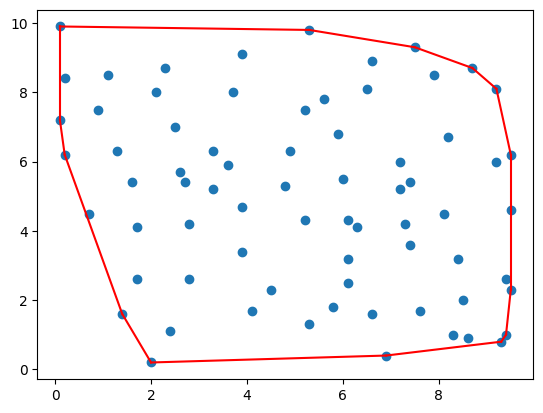

In [16]:
# plot the data set pines with the convex hull overlayed
point.plot(C4,jm1)

Now do the same again but this time with the random dataset.

In [17]:
# open the file
with open('random.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    R1 = []
    R2 = []
    # read each row of the file ...
    for row in csv_reader :
        # .. and put the data into the lists
        R1.append(row[0])
        R2.append(row[1])

# have a look
#print(R1,R2)

In [18]:
!head random.csv

0.237561302163444,0.765067715276005
-0.19666778615857,1.05818498574564
-0.403757362758993,0.906347297954807
-0.015823698629412,0.63745400404586
-0.71657388106957,1.20219702232312
-0.404177827637558,0.882928472674566
-0.0711562803815665,0.859002158330444
-0.294185993867548,0.766546052705214
-0.339267115522964,1.09901149860526
-0.30695534656493,1.16131675596982


In [19]:
# convert from strings to floats
R1 = [float(x) for x in R1]
R2 = [float(x) for x in R2]

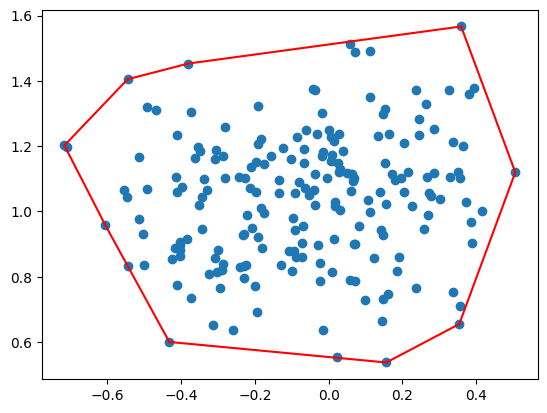

In [20]:
# find convex hull and plot it
R3 = point.list_to_points(R1,R2)
R4 = jarvis_march(R1,R2)
point.plot(R3,R4)

In [21]:
# actually print the dataset to have a look at the points in the convex hull
[point.print(R4[i]) for i in range(len(R4))]

( -0.71657388106957 , 1.20219702232312 )
( -0.605200231305254 , 0.957134110706781 )
( -0.432249029757549 , 0.600185398765638 )
( 0.156196864138666 , 0.537196258340319 )
( 0.353922330922547 , 0.654945271536898 )
( 0.505823570824408 , 1.12001307650065 )
( 0.358984412999769 , 1.56677311480003 )
( -0.380951747864001 , 1.45310545712829 )
( -0.545292317957066 , 1.4050365090573 )


[None, None, None, None, None, None, None, None, None]

Now to try out the dataset 'pgram'.

In [22]:
!head pgram.csv

1,1
2,1
3,2
2,2
2.0,1.5
2.5,2.5

In [23]:
# open the file
with open('pgram.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    P1 = []
    P2 = []
    # read each row of the file ...
    for row in csv_reader:
        # .. and put the data into the lists
        P1.append(row[0])
        P2.append(row[1])

# have a look
print(P1,P2)
# this throws an index error because the final few rows of the file are empty so it can't append anything.
# however it still adds all the things we want to the lists so it's not causing an issue.

['1', '2', '3', '2', '2.0', '2.5'] ['1', '1', '2', '2', '1.5', '2.5']


In [24]:
# convert from strings to floats
P1 = [float(x) for x in P1]
P2 = [float(x) for x in P2]

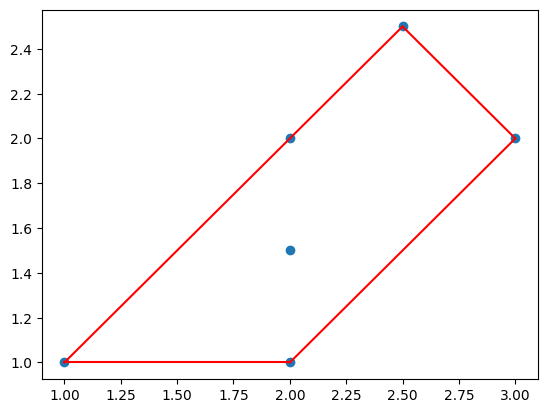

In [25]:
# find convex hull and plot it
P3 = point.list_to_points(P1,P2)
P4 = jarvis_march(P1,P2)
point.plot(P3,P4)

Note that some places may define the convex hull as the smallest subset of points containing all other points (thus in the case above getting ride of the point (2,2)). I am not defining it this way, so that point stays in. My definition follows the algorithms explaination; a point is on the convex hull if every other point not in the hull is anticlockwise to it.

Now trying the dataset 'square'.

In [26]:
!head square.csv

1,1
2,1
2,2
1,2
1.5,1.5
1.5,2.5


In [27]:
# open the file
with open('square.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    S1 = []
    S2 = []
    # read each row of the file ...
    for row in csv_reader:
        # .. and put the data into the lists
        S1.append(row[0])
        S2.append(row[1])

# have a look
print(S1,S2)

['1', '2', '2', '1', '1.5', '1.5'] ['1', '1', '2', '2', '1.5', '2.5']


In [28]:
# convert points from strings to floats
S1 = [float(x) for x in S1]
S2 = [float(x) for x in S2]

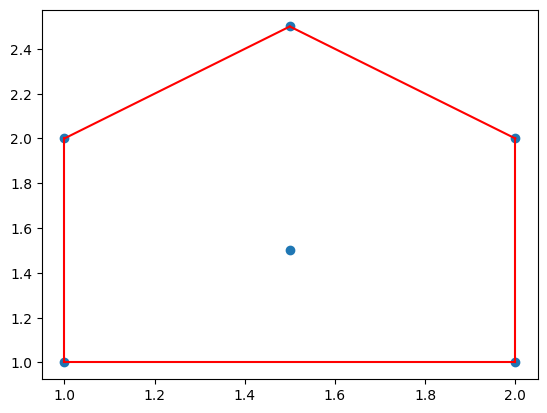

In [29]:
# calculate convex hull and plot it
S3 = point.list_to_points(S1,S2)
S4 = jarvis_march(S1,S2)
point.plot(S3,S4)

Now for the dataset 'line'.

In [30]:
# open the file
with open('line.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    L1 = []
    L2 = []
    # read each row of the file ...
    for row in csv_reader:
        # .. and put the data into the lists
        L1.append(row[0])
        L2.append(row[1])

# have a look
print(L1,L2)

['1', '2', '3'] ['1', '2', '3']


In [31]:
# convert from strings to floats
L1 = [float(x) for x in L1]
L2 = [float(x) for x in L2]

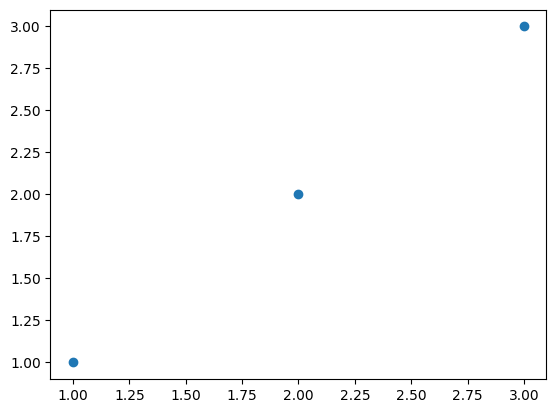

In [32]:
# convert to list of points and plot them
L3 = point.list_to_points(L1,L2)
point.plot(L3)

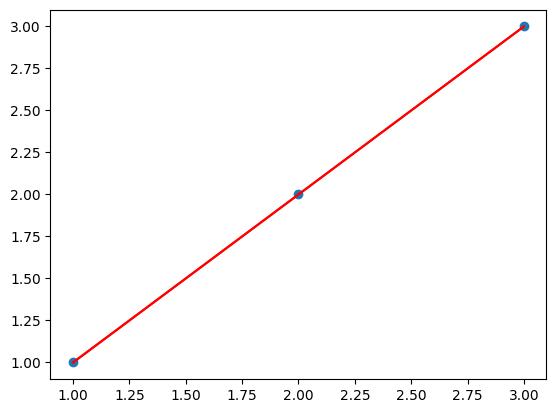

In [33]:
# calculate convex hull and plot it
L4 = jarvis_march(L1,L2)
point.plot(L3,L4)

In [34]:
# since i am not defining the convex hull as the smallest set of points, every point in the line is on the hull
# if one wanted just the first and last point they would have to plot it and make that decision themselves
[point.print(L4[i]) for i in range(len(L4))]

( 1.0 , 1.0 )
( 2.0 , 2.0 )
( 3.0 , 3.0 )


[None, None, None]

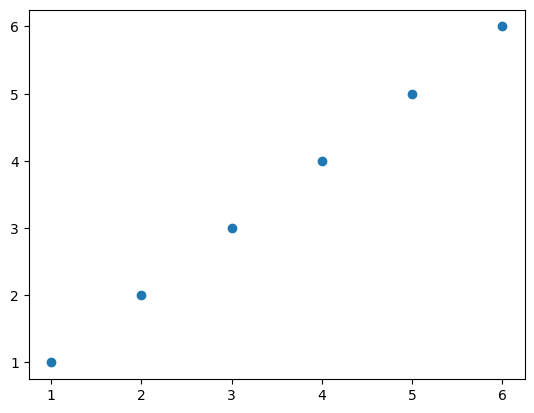

In [35]:
# trying a test data set for a set of points forming a line longer than just three points to make sure that
# the algorithm works for that too
testline = [1,2,3,4,5,6]
testline = [float(x) for x in testline]
testline = point.list_to_points(testline,testline)
point.plot(testline)

In [36]:
testline = [1,2,3,4,5,6]
testline = [float(x) for x in testline]
testlinem = jarvis_march(testline,testline)
[point.print(testlinem[i]) for i in range(len(testlinem))]

( 1.0 , 1.0 )
( 2.0 , 2.0 )
( 3.0 , 3.0 )
( 4.0 , 4.0 )
( 5.0 , 5.0 )
( 6.0 , 6.0 )


[None, None, None, None, None, None]

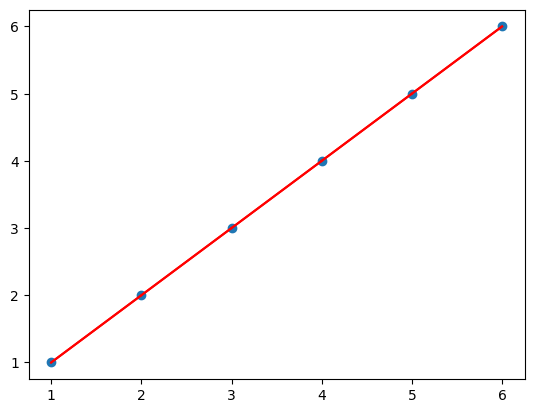

In [37]:
# plotting the convex hull of this line
point.plot(point.list_to_points(testline,testline),testlinem)

In terms of the 'big O' notation, I estimate that my code is $\mathcal{O} (nh)$ where $n$ is the number of points in the set and $h$ is the number of points on the hull. In the worst case, $h=n$ and the algorithm is $\mathcal{O}(n^2)$. This estimate comes from the fact I have a while loop the length of the hull and a for loop within that while loop which is the length of the input set. Here I am talking about exclusively the algorithm for finding the hull itself, not including any of the 'checks' at the beginning. If we include these checks, the function convex_hull has $\mathcal{O}(nh+n+1+1)$. The additional $n$ comes from converting the inputs lists into a list of points (which is a for loop of length $n$). The two additional 1's come from checking the input lists are both he same length and longer than 3. Obviously as the size of $n$ and/or $h$ increases, the influence the additional 1's have will become increasingly negligible.

For testing how long the code takes to run I am going to randomly generate datasets of different sizes, run the algorithm and plot how long it takes to run.

In [38]:
# this randomly generates x and y coordinates and puts them in a list. this is inside a bigger list
# so that each list is of a different sampe size so time can be measured for different inputs.
import random
random.seed(1313)
# setting the seed for reproduacability
n = [10,50,100,200,500,800,1000,5000]
timedatax = [[],[],[],[],[],[],[],[]]
timedatay = [[],[],[],[],[],[],[],[]]
for x in range(len(n)):
    while len(timedatax[x])<n[x]:
        timedatax[x].append(random.random())
for x in range(len(n)):
    while len(timedatay[x])<n[x]:
        timedatay[x].append(random.random())

In [39]:
import time

In [40]:
# trying out timing it 
times = []
for i in range(len(timedatax)):
    st = time.time()
    jm = jarvis_march(timedatax[i],timedatay[i])
    en = time.time()
    elapsed = en - st
    times.append(elapsed)

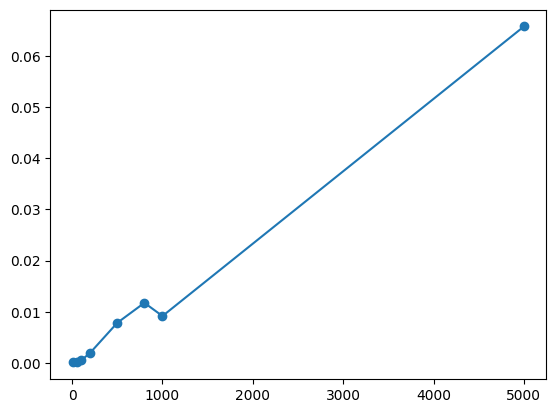

In [41]:
# plot the times for those sample sizes in seconds against the respective input size
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(n, times,marker='o')

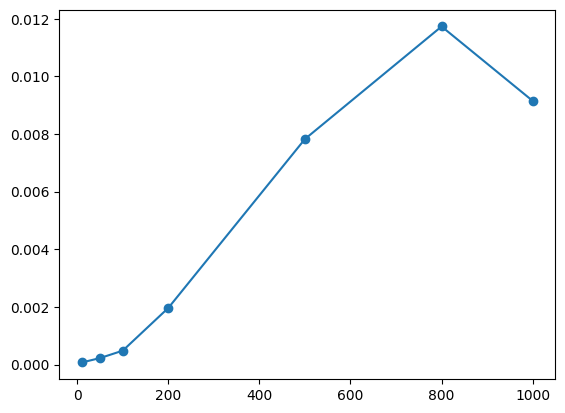

In [42]:
# the points at the beginning are somewhat bunched up so plot all but the last point
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(n[:-1], times[:-1],marker='o')

In [43]:
# doing this process again for bigger sample sizes
random.seed(131313)
n2 = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
timedata2x = [[]]*len(n2)
timedata2y = [[]]*len(n2)
for x in range(len(n2)):
    while len(timedata2x[x])<n2[x]:
        timedata2x[x].append(random.random())
for x in range(len(n2)):
    while len(timedata2y[x])<n2[x]:
        timedata2y[x].append(random.random())

In [44]:
times2 = []
for i in range(len(timedata2x)):
    st = time.time()
    jm = jarvis_march(timedata2x[i],timedata2y[i])
    en = time.time()
    elapsed = en - st
    times2.append(elapsed)

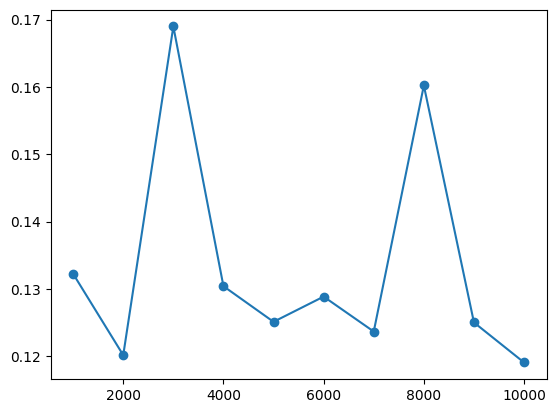

In [45]:
fig, ax = plt.subplots()
ax.plot(n2, times2,marker='o')

In [46]:
# for ease put this whole plotting time process in a function with the sample sizes wanted as the input
def time_jarvis_march_plot(n,seed):
    timedatax = [[]]*len(n)
    timedatay = [[]]*len(n)
    random.seed(seed)
    for x in range(len(n)):
        while len(timedatax[x])<n[x]:
            timedatax[x].append(random.random())
    for x in range(len(n)):
        while len(timedatay[x])<n[x]:
            timedatay[x].append(random.random())
    times = []
    for i in range(len(timedatax)):
        st = time.time()
        jm = jarvis_march(timedatax[i],timedatay[i])
        en = time.time()
        elapsed = en - st
        times.append(elapsed)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(n, times, marker='o')

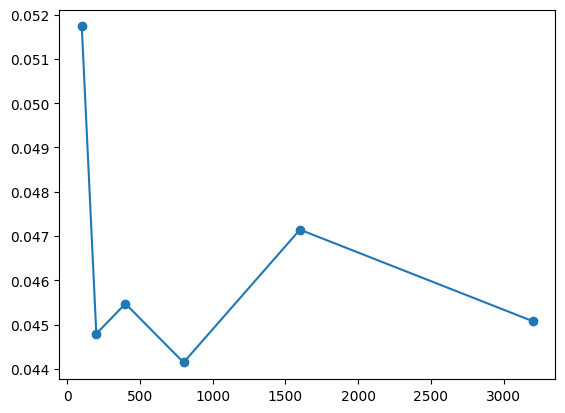

In [47]:
# trying out this function
time_jarvis_march_plot([100,200,400,800,1600,3200],1989)

In [48]:
# same as above but now generating samples from a normal dist. This is because all the points generated in
# the uniform case meant there were lots of points on the edge. 
def time_jarvis_march_normal_plot(n,seed):
    import numpy as np
    timedatax = [[]]*len(n)
    timedatay = [[]]*len(n)
    random.seed(seed)
    for x in range(len(n)):
        timedatax[x] = list(np.random.normal(7,1.5,n[x]))
    for x in range(len(n)):
        timedatay[x] = list(np.random.normal(7,1.5,n[x]))
    times = []
    for i in range(len(timedatax)):
        st = time.time()
        jm = jarvis_march(timedatax[i],timedatay[i])
        en = time.time()
        elapsed = en - st
        times.append(elapsed)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(n, times, marker='o')

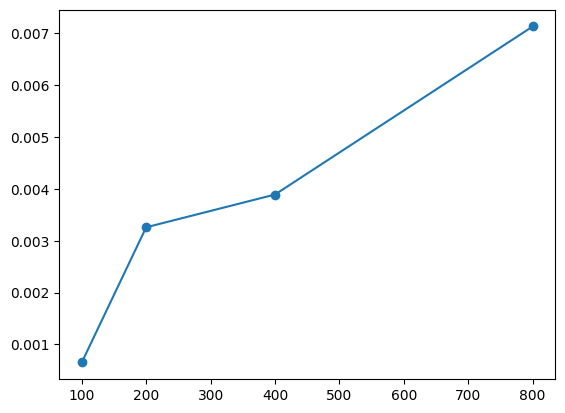

In [49]:
time_jarvis_march_normal_plot([100,200,400,800],1313)

In [50]:
# creating the same function as above but without the plotting bit
# this way it can be used in the function below to find averages
def time_jarvis_march(n,seed):
    import numpy as np
    timedatax = [[]]*len(n)
    timedatay = [[]]*len(n)
    random.seed(seed)
    for x in range(len(n)):
        timedatax[x] = list(np.random.normal(7,1.5,n[x]))
    for x in range(len(n)):
        timedatay[x] = list(np.random.normal(7,1.5,n[x]))
    times = []
    for i in range(len(timedatax)):
        st = time.time()
        jm = jarvis_march(timedatax[i],timedatay[i])
        en = time.time()
        elapsed = en - st
        times.append(elapsed)
    return times

In [51]:
def time_jarvis_march_average(n,reps,seed):
    times = []
    for i in range(reps):
        times.append(time_jarvis_march(n,seed))
    means = []
    for j in range(len(times[0])):
        means.append(sum(times[i][j] for i in range(len(times)))/len(times))
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(n, means, marker='o')

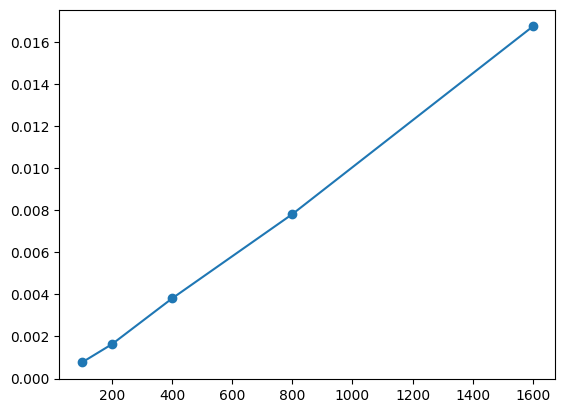

In [52]:
time_jarvis_march_average([100,200,400,800,1600],200,1313)

This is roughly showing the quadratic curve we would expect! Now trying with data generated from a circle. This means that all the data points are on a circle, thus the whole data set is in the hull, so that is the worst case scenario we would expect, time wise.

First lets check that the algorithm works for a circular set of points!

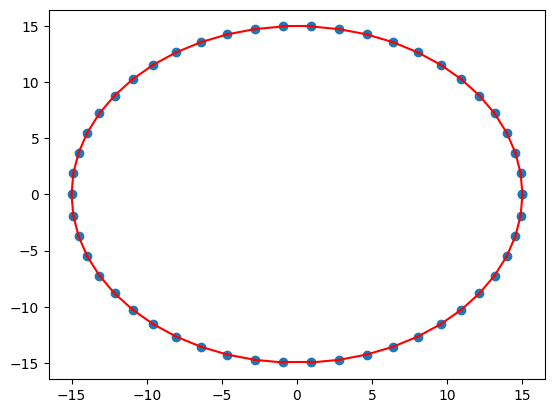

In [53]:
import math
pi = math.pi

circledatax = [math.cos(2*pi/50*x)*15 for x in range(0,50+1)]
circledatay = [math.sin(2*pi/50*x)*15 for x in range(0,50+1)]
circle = point.list_to_points(circledatax,circledatay)
circlejm = jarvis_march(circledatax,circledatay)
point.plot(circle,circlejm)

In [54]:
import math
pi = math.pi

def time_jarvis_march_circle(n,r):
    import numpy as np
    timedatax = [[]]*len(n)
    timedatay = [[]]*len(n)
    for h in range(len(n)):
        timedatax[h] = [math.cos(2*pi/n[h]*x)*r for x in range(0,n[h]+1)]
    for h in range(len(n)):
        timedatay[h] = [math.sin(2*pi/n[h]*x)*r for x in range(0,n[h]+1)]
    times = []
    for i in range(len(timedatax)):
        st = time.time()
        jm = jarvis_march(timedatax[i],timedatay[i])
        en = time.time()
        elapsed = en - st
        times.append(elapsed)
    return times

In [55]:
def time_jarvis_march_circle_average(n,r,reps):
    times = []
    for i in range(reps):
        times.append(time_jarvis_march_circle(n,r))
    means = []
    for j in range(len(times[0])):
        means.append(sum(times[i][j] for i in range(len(times)))/len(times))
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(n, means, marker='o')

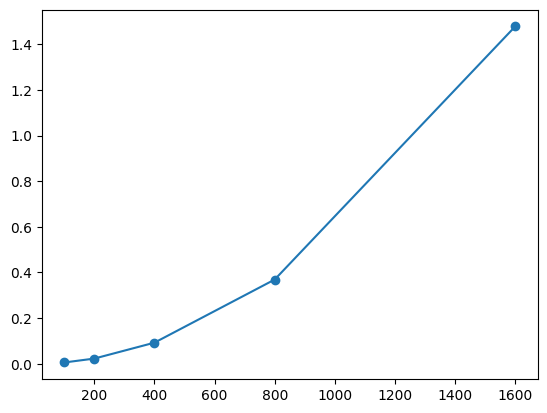

In [56]:
# warning: this cell takes a little while to run (a few minutes) so be aware of that before re-running this cell
time_jarvis_march_circle_average([100,200,400,800,1600],15,50)

This is again showing the curve we expect! However the times on the $y$ axis are clearly a lot bigger than the times on the $y$ axis for the points generated from a normal distribution. It would be nice to plot them together which is what the code below does:

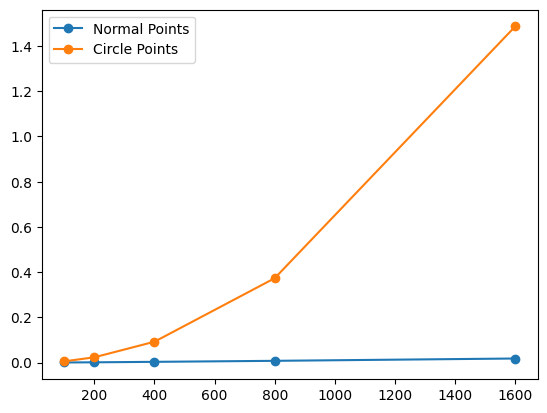

In [57]:
n = [100,200,400,800,1600]
reps = 10
seed = 1313
timesnormal = []
for i in range(reps):
    timesnormal.append(time_jarvis_march(n,seed))
meansnormal = []
for j in range(len(timesnormal[0])):
    meansnormal.append(sum(timesnormal[i][j] for i in range(len(timesnormal)))/len(timesnormal))
        
timescircle = []
for i in range(reps):
    timescircle.append(time_jarvis_march_circle(n,15))
meanscircle = []
for j in range(len(timescircle[0])):
    meanscircle.append(sum(timescircle[i][j] for i in range(len(timescircle)))/len(timescircle))


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(n, meansnormal, marker='o', label="Normal Points")
ax.plot(n, meanscircle, marker='o', label="Circle Points")
plt.legend()
plt.show()

It's hard to see the times for the points generated using the normal distribution so if we log the times and have a look at that plot...

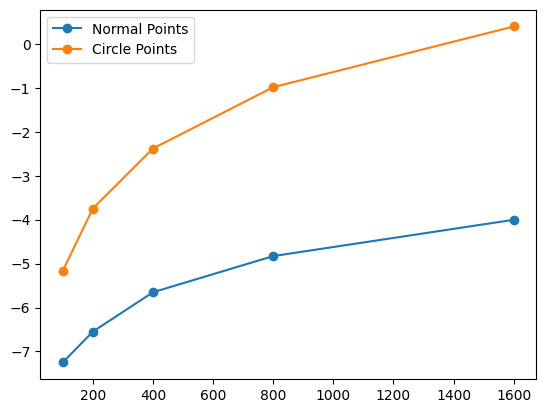

In [58]:
logmeansnormal = []
logmeanscircle = []
for i in range(len(meansnormal)):
    logmeansnormal.append(math.log(meansnormal[i]))
for i in range(len(meanscircle)):
    logmeanscircle.append(math.log(meanscircle[i]))
fig, ax = plt.subplots()
ax.plot(n, logmeansnormal, marker='o', label="Normal Points")
ax.plot(n, logmeanscircle, marker='o', label="Circle Points")
plt.legend()
plt.show()           

This allows us to quantify how much longer the algorithm is taking when the whole data set is the convex hull. The code below generates 100 instances of points from the normal distribution (each with 1000 points in them) and calculates what proportion of the data set is in the convex hull. 

In [59]:
import numpy as np
num = 1000
reps = 100
normalpointsx = [[]]*reps
normalpointsy = [[]]*reps
random.seed(191389)
for x in range(reps):
    normalpointsx[x] = list(np.random.normal(7,1.5,num))
for x in range(reps):
    normalpointsy[x] = list(np.random.normal(7,1.5,num))
jmlength = []
for u in range(reps):
    jmlength.append(len(jarvis_march(normalpointsx[u],normalpointsy[u]))/num)
print(jmlength)
print(np.mean(jmlength))

[0.008, 0.011, 0.011, 0.012, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.015, 0.012, 0.012, 0.01, 0.01, 0.017, 0.013, 0.012, 0.014, 0.013, 0.01, 0.012, 0.01, 0.01, 0.012, 0.014, 0.011, 0.011, 0.011, 0.012, 0.01, 0.009, 0.013, 0.009, 0.013, 0.011, 0.011, 0.01, 0.01, 0.011, 0.015, 0.009, 0.012, 0.01, 0.011, 0.011, 0.013, 0.014, 0.012, 0.011, 0.014, 0.012, 0.01, 0.013, 0.011, 0.009, 0.013, 0.011, 0.011, 0.012, 0.011, 0.013, 0.011, 0.012, 0.009, 0.009, 0.012, 0.014, 0.016, 0.014, 0.012, 0.011, 0.013, 0.01, 0.014, 0.015, 0.009, 0.012, 0.011, 0.011, 0.011, 0.01, 0.011, 0.012, 0.009, 0.01, 0.014, 0.014, 0.011, 0.009, 0.012, 0.012, 0.014, 0.013, 0.012, 0.014, 0.009, 0.009, 0.016, 0.014]
0.011619999999999998


This gives an average of $\approx 1.1\%$ of the size of the input set. The plot below is a visual reference of what this looks like with $\approx 11$ points out of 1000 being in the convex hull.

13

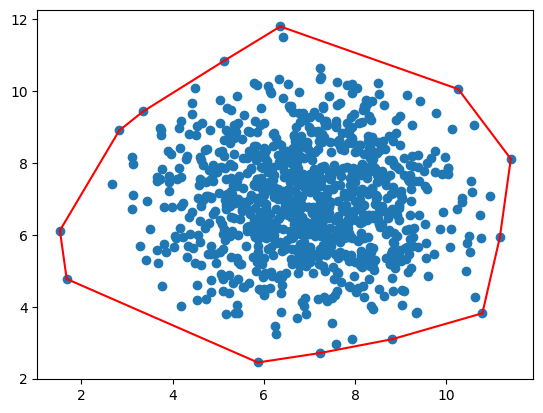

In [60]:
random.seed(131313)
normalpointsx = list(np.random.normal(7,1.5,1000))
normalpointsy = list(np.random.normal(7,1.5,1000))
normaljm = jarvis_march(normalpointsx,normalpointsy)
point.plot(point.list_to_points(normalpointsx,normalpointsy),normaljm)
len(normaljm)

In [61]:
dif = []
for i in range(len(meansnormal)):
    dif.append(meanscircle[i]/meansnormal[i])
print(dif)

[8.041971660734673, 16.458278564416563, 26.35246608747631, 46.71505705123425, 81.4015550942066]


Thus we can see that the algoithm is $\approx 0.07n$ times slower when the hull is the whole set compared with when the convex hull is ~1.1% the size of the set of points.